Predicting whether a given tweet is about a real disaster or not. <br>
If so, target is 1 and 0 if not. <br><br>

Data contains : <br>
keyword  : A keyword from that tweet (although this may be blank) <br>
location : The location the tweet was sent from (may also be blank) <br>
text     : The text of a tweet

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import tensorflow as tf
from tensorflow.keras import layers

### Import data

In [4]:
train_df = pd.read_csv("raw_data/train.csv")
test_df = pd.read_csv("raw_data/test.csv")

<b>Show particular data</b>

In [5]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


### Data Exploration

In [7]:
print('There are {} rows and {} columns in train'.format(train_df.shape[0],train_df.shape[1]))
print('There are {} rows and {} columns in test'.format(test_df.shape[0],test_df.shape[1]))

There are 7613 rows and 5 columns in train
There are 3263 rows and 4 columns in test


<b> Show data description</b>

In [8]:
print("Count null data")
print(train_df.isna().sum(),"\n")

print("text and target are complete")

Count null data
id             0
keyword       61
location    2533
text           0
target         0
dtype: int64 

text and target are complete


In [9]:
print("Unique values for keyword : ",train_df['keyword'].nunique())
print("Count non-NaN : ",train_df['keyword'].count())
print("Unique values for location : ",train_df['location'].nunique())
print("Count non-NaN : ",train_df['location'].count())

Unique values for keyword :  221
Count non-NaN :  7552
Unique values for location :  3341
Count non-NaN :  5080


But this is nlp case, the only one affect the target is the text <br>
Don't need to pay attention to other features

comparing amount of both target class :
0    4342
1    3271
Name: target, dtype: int64 



Text(0,0.5,'amount')

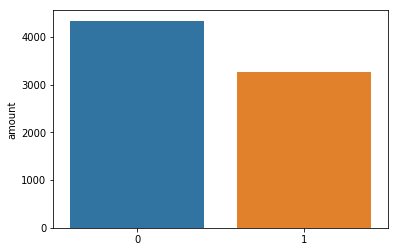

In [10]:
print("comparing amount of both target class :")
count_value = train_df['target'].value_counts()
print(count_value,"\n")

sns.barplot(count_value.index,count_value)
plt.gca().set_ylabel('amount')

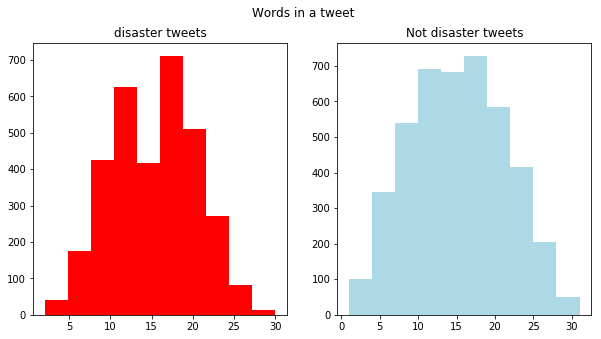

In [11]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=train_df[train_df['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=train_df[train_df['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='lightblue')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

### Data Cleaning

In [12]:
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from collections import defaultdict
from collections import  Counter
from spellchecker import SpellChecker
import re
import string

In [13]:
print("remove URL")
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

train_df["text"] = [remove_URL(text) for text in train_df["text"]]
test_df["text"] = [remove_URL(text) for text in test_df["text"]]

remove URL


In [14]:
print("remove HTML tag")
def remove_html_tag(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

train_df["text"] = [remove_html_tag(text) for text in train_df["text"]]
test_df["text"] = [remove_html_tag(text) for text in test_df["text"]]

remove HTML tag


In [15]:
print("remove emoji")
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

train_df["text"] = [remove_emoji(text) for text in train_df["text"]]
test_df["text"] = [remove_emoji(text) for text in test_df["text"]]

remove emoji


In [16]:
print("Remove punctuation")
def remove_punctuation(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

train_df["text"] = [remove_punctuation(text) for text in train_df["text"]]
test_df["text"] = [remove_punctuation(text) for text in test_df["text"]]

Remove punctuation


In [17]:
print("spell checking")
spell = SpellChecker()

def correct_spellings(text):
    corrected_text = []
    # find those words that may be misspelled
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

train_df["text"] = [correct_spellings(text) for text in train_df["text"]]
test_df["text"] = [correct_spellings(text) for text in test_df["text"]]

spell checking


KeyboardInterrupt: 

In [ ]:
print("Tokenization")

train = [word_tokenize(text) for text in train_df["text"]]
test = [word_tokenize(text) for text in test_df["text"]]

In [ ]:
print("Normalization")

train = [[word.lower() for word in text]for text in train["text"]]
test = [[word.lower() for word in text]for text in test["text"]]

In [ ]:
print("Remove stopwords")

stop_words = set(stopwords.words('english'))
train = [[word for word in text if not word in stop_words] for text in train["text"]]
test = [[word for word in text if not word in stop_words] for text in test["text"]]

In [ ]:
print("Remove non alphabetic")

train = [[word for word in text if word.isalpha()] for text in train["text"]]
test = [[word for word in text if word.isalpha()] for text in test["text"]]